In [ ]:
!git clone https://github.com/mesahwi/Birdsong_Continuity.git

In [ ]:
%cd Birdsong_Continuity

In [ ]:
!bash get_data.sh

In [4]:
from misc import *
import compute_continuity

import numpy as np
import pandas as pd

import scipy.io

In [5]:
# Loading data
audioevt_onset = np.load('Data/audioevt_onset.npy')
audioevt_duration = np.load('Data/audioevt_duration.npy')
audioevt_isdir = np.load('Data/audioevt_isdir.npy')
audioevt_group = np.load('Data/audioevt_group.npy')
audioevt_fsource = np.load('Data/audioevt_fsource.npy')

spk_cluster = np.load('Data/spk_cluster.npy')
spk_fsource = np.load('Data/spk_fsource.npy')
spk_times = np.load('Data/spk_times.npy')

audioevt_group_info = pd.read_csv('Data/audioevt_group_info.tsv', delimiter='\t', header=0)
file_info = pd.read_csv('Data/file_info.tsv', delimiter='\t', header=0)
spk_cluster_info = pd.read_csv('Data/spk_cluster_info.tsv', delimiter='\t', header=0)

vocal_data = scipy.io.loadmat('Data/vocal_data_g4r4_20190718_02.mat')
spec_files = vocal_data['specs'][0]

In [6]:
## Audio Data (Start and Duration)
audioevt_properties = pd.DataFrame()

aud_idx1 = np.isin(audioevt_group, [2]) #syllable A
aud_idx2 = np.isin(audioevt_fsource, [1]) #first file

aud_idx = aud_idx1

audioevt_properties['evt_id'] = np.arange(len(audioevt_onset[aud_idx]))
audioevt_properties['syllable_start'] = audioevt_onset[aud_idx]
audioevt_properties['duration'] = audioevt_duration[aud_idx]
audioevt_properties['file_num'] = audioevt_fsource[audioevt_group==2]

In [7]:
##Getting rid of faulty syllables : 213, 312, 431
audioevt_properties.drop(index=[213,312,431], inplace=True)
audioevt_properties['evt_id'] = np.arange(audioevt_properties.shape[0])
audioevt_properties.reset_index(drop=True, inplace=True)
audioevt_properties

,evt_id,syllable_start,duration,file_num
0,0,2347741,7775,1
1,1,2356481,7637,1
2,2,2365884,7613,1
3,3,2378125,7557,1
4,4,2488812,7530,1
...,...,...,...,...
573,573,875109,7588,11
574,574,884463,7602,11
575,575,896732,7452,11
576,576,909070,7501,11


In [8]:
neural2spectral_delay = ms2samples(30,20)
neural_bin_size = ms2samples(10, 20)

In [9]:
spectral_full_window = [ms2samples(0,20), ms2samples(400,20)]
neural_full_window = [ms2samples(0,20)-neural2spectral_delay, ms2samples(400,20)-neural2spectral_delay]

### Spectrogram

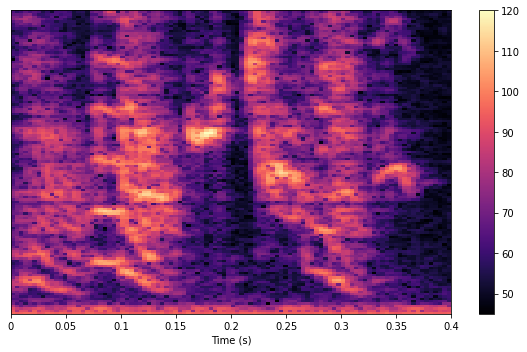

In [10]:
spectral_full_activity = get_spectral_activity(spec_files, audioevt_properties, spectral_full_window)
plot_spectrogram(spectral_full_activity, title=None)

## neural

In [11]:
total_channels = spk_cluster_info['id'].unique()
channels_of_interest = total_channels[(total_channels >= 220) & (total_channels <= 300)] #LMAN

In [12]:
neural_properties_list = get_neural_properties_list(audioevt_fsource, spk_fsource, spk_cluster_info, spk_times, spk_cluster)

In [13]:
neural_properties_list[0] ## for first file

,channel_id,file_num,spikes
0,0,1,[]
1,1,1,[]
2,2,1,[]
3,3,1,"[300, 585, 717, 857, 1085, 1219, 1440, 1566, 1..."
4,4,1,[]
...,...,...,...
261,304,1,"[10454, 11955, 36231, 36389, 36997, 39481, 397..."
262,305,1,"[5080, 9415, 10327, 10335, 10849, 11003, 13077..."
263,306,1,"[435, 1096, 2462, 2962, 3835, 5657, 8189, 8596..."
264,307,1,"[521439, 1168810, 2437865, 3048073, 3048215, 3..."


## Raster

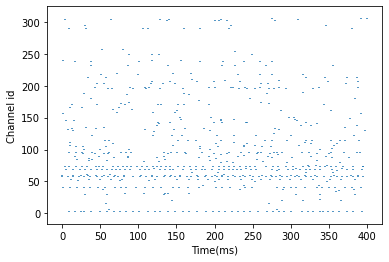

In [14]:
plot_raster(audioevt_onset, neural_properties_list, 0, 0, neural_full_window, channels_of_interest=neural_properties_list[0]['channel_id'])

# compute continuity

In [ ]:
o = compute_continuity.continuity_computation(neural_properties_list, spec_files, audioevt_properties, 
                                              channels_of_interest, neural_full_window, spectral_full_window, neural_bin_size=neural_bin_size, spectral_bin_size=80)

o.to_csv('KNN_results/naive_knn.csv')